In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import pickle
import torchtext
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

debug = False

print("Pytorch: \t\t", torch.__version__)
if not debug and torch.cuda.is_available():
    device='cuda'
    print('GPU:         \t\t', torch.cuda.get_device_name(0))
    print('Memory Usage:\t',
        round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB / ',
        round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    
    torch.backends.cudnn.benchmark = True
else:
    print("GPU is **not available**")
    device='cpu'

Pytorch: 		 1.10.2+cu102
GPU:         		 NVIDIA GeForce GTX 1660 Ti
Memory Usage:	 0.0 GB /  0.0 GB


In [2]:
proj_src_root = pathlib.Path().absolute()
glove_path = proj_src_root / ".vector_cache"


print(f"Project Source Root Path: {proj_src_root}")
print(f"Project Vectors Path: {glove_path}")

Project Source Root Path: /home/addy/pytorch/beginner_trail
Project Vectors Path: /home/addy/pytorch/beginner_trail/.vector_cache


In [3]:
emb_dim = 50
specials=["<pad>", "<unk>"]

if(glove_path / f'6B.{emb_dim}_words.pkl').exists():
    words = pickle.load(open(glove_path / f'6B.{emb_dim}_words.pkl', 'rb'))
    word2idx = pickle.load(open(glove_path / f'6B.{emb_dim}_idx.pkl', 'rb'))
    vectors = pickle.load(open(glove_path / f'6B.{emb_dim}_vecs.pkl', 'rb'))
else:
    words = []
    idx = 0
    word2idx = {}
    vectors = []


    for word in specials:
        words.append(word)
        word2idx[word] = idx
        idx += 1
        vect = np.random.normal(scale=0.6, size=(emb_dim, ))
        vectors.append(vect)

    with open(glove_path / 'glove.6B.50d.txt', 'rb') as f:
        for l in f:
            line = l.decode().split()
            word = line[0]
            words.append(word)
            word2idx[word] = idx
            idx += 1
            vect = np.array(line[1:]).astype(float)
            vectors.append(vect)
        
    vectors = np.vstack(vectors)
    pickle.dump(vectors, open(glove_path / f'6B.{emb_dim}_vecs.pkl', 'wb'))
    pickle.dump(words, open(glove_path / f'6B.{emb_dim}_words.pkl', 'wb'))
    pickle.dump(word2idx, open(glove_path / f'6B.{emb_dim}_idx.pkl', 'wb'))

In [4]:
len(words), len(word2idx), vectors.shape

(400002, 400002, (400002, 50))

In [5]:
# Initializing parameters

batch_size = 32     # Reduce this if you get memory errors

seed = 2476          # A random seed to get replicable results

sequence_max_length = 250

vocab_size = 10000

In [6]:
train_dataset, test_dataset = torchtext.datasets.IMDB(split=('train', 'test'))

In [7]:

from torchtext.data.functional import to_map_style_dataset

train_dataset = to_map_style_dataset(train_dataset)
test_dataset = to_map_style_dataset(test_dataset)

In [8]:
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer('basic_english')

In [9]:
from collections import Counter, OrderedDict

vocab_size = 10000

counter = Counter()
for _, text in train_dataset:
    counter.update(tokenizer(text.lower()))

if specials is not None:
    for tok in specials:
        del counter[tok]

counter = counter.most_common(vocab_size)

indices = [] 
new_words = []

for word in specials:
    indices.append(word2idx[word])
    new_words.append(word)

for word, _ in counter:
    if word in word2idx:
        indices.append(word2idx[word])
        new_words.append(word)

vectors = vectors[indices]
words = new_words
word2idx = {}
for index, word in enumerate(words):
    word2idx[word] = index

In [10]:
unkn_id = word2idx['<unk>']

def text_pipeline(x):
    res = []
    for i in tokenizer(x):
        if i in word2idx:
            res.append(word2idx[i])
        else:
            res.append(unkn_id)
    return res


def rev_text_pipeline(x):
    return [words[i] for i in x]

label_pipeline = lambda x: 1 if x == 'pos' else 0

In [11]:
pad_id = word2idx['<pad>']
pad_id

0

## Avoiding ValueError (using a target size different to the input size)

```ValueError: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])) is deprecated. Please ensure they have the same size.```

Simply add `.unsqueeze(-1)` to the end of your label tensor.



In [12]:
def collate_batch(batch):
     label_list, text_list = [], []
     for (label, text) in batch:
          input = text_pipeline(text)
          label_list.append(torch.tensor([label_pipeline(label)], dtype=torch.float32))
          
          a = torch.tensor(input[:sequence_max_length], dtype=torch.int64)
          b = torch.zeros(max(0, sequence_max_length - len(input)), dtype=torch.int64)
          text_list.append(torch.cat((a,b)))
               
     label_list = torch.stack(label_list)
     text_list = torch.stack(text_list)
     return text_list, label_list

In [13]:
train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    num_workers=8,
    batch_size=batch_size,
    collate_fn=collate_batch)

test_dataloader = DataLoader(
    test_dataset, 
    num_workers=8,
    batch_size=batch_size, 
    collate_fn=collate_batch)


In [14]:

for X, y in train_dataloader:
    print("Shape of X: ", X.shape)
    print("Labels : ", y.shape)
    print("SAMPLE")
    print("Label: ",y[0].item())
    print("Text:")
    print(" ".join(rev_text_pipeline(X[0].tolist())))
    # print(X, y, o)
    break

Shape of X:  torch.Size([32, 250])
Labels :  torch.Size([32, 1])
SAMPLE
Label:  1.0
Text:
extremely <unk> - part whatever happened to , part behind the scenes <unk> , part reunion film - all done in the same campy style that made the original series so much fun . i only wish this had been done 10 years ago to include more guest villains who have passed on . <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad

In [15]:
from torch import nn

def create_emb_layer(weights_matrix, non_trainable=False):
    num_embeddings, embedding_dim = weights_matrix.shape
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    emb_layer.load_state_dict({'weight': weights_matrix})
    if non_trainable:
        emb_layer.weight.requires_grad = False

    return emb_layer, num_embeddings, embedding_dim


class ClassifyNet(nn.Module):

    def __init__(self, num_class, word_weights, hidden_size = 100, num_layers = 2):
        super().__init__()
        self.emb, _, embed_dim = create_emb_layer(word_weights, True)
        # self.emb = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(input_size=embed_dim,
                    hidden_size=hidden_size, num_layers=num_layers,
                    dropout=0.5, batch_first=True,
                    bidirectional=True)
        self.fc = nn.Linear(num_layers * hidden_size, num_class)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.emb(x)
        # Propagate the input through LSTM layer/s
        _, (h, _) = self.lstm(x)

        # Extract output of the last time step
        # Extract forward and backward hidden states of the
        # last time step
        x = torch.cat([h[-2,:,:],h[-1,:,:]], dim=1)
        
        x = self.dropout(x)
        # print(x.shape)
        x = self.fc(x)

        return torch.sigmoid(x)

In [16]:
def train_loop(dataloader, model, loss_fn, optimizer, history):
    size = len(dataloader.dataset)
    accuracy = 0
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        
        #FORWARD PASS
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss = loss.item()
        accuracy += (torch.round(pred) == y).type(torch.float).sum().item()

        # if batch % 100 == 0:
        #     loss, current = loss.item(), batch * len(X)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    accuracy /= size
    history['train_loss'].append(loss)
    history['train_accuracy'].append(accuracy)
    return loss, accuracy


def test_loop(dataloader, model, loss_fn, history):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, accuracy = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            
            pred = model(X)
            
            loss += loss_fn(pred, y).item()
            accuracy += (torch.round(pred) == y).type(torch.float).sum().item()

    loss /= num_batches
    accuracy /= size

    history['test_loss'].append(loss)
    history['test_accuracy'].append(accuracy)
    return loss, accuracy

In [17]:
vectors.shape

(9967, 50)

In [18]:
num_classes = 1

model = ClassifyNet(num_classes, torch.from_numpy(vectors)).to(device)
    
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())



In [19]:
print(model)

ClassifyNet(
  (emb): Embedding(9967, 50)
  (lstm): LSTM(50, 100, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=200, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [20]:
count = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {count}")

Number of trainable parameters: 363401


In [21]:
epochs = 10
history = {
    'train_loss':[],
    'train_accuracy':[],
    'test_loss':[],
    'test_accuracy':[]
}

for t in tqdm(range(epochs), bar_format="{elapsed} Elapsed | {percentage:3.0f}% done |{bar}| {n_fmt}/{total_fmt} [{remaining} remaining | {rate_fmt}{postfix}]", unit="epoch", total=epochs):
    train_loop(train_dataloader, model, loss_fn, optimizer, history)
    test_loop(test_dataloader, model, loss_fn, history)

06:49 Elapsed | 100% done |██████████| 10/10 [00:00 remaining | 40.91s/epoch]


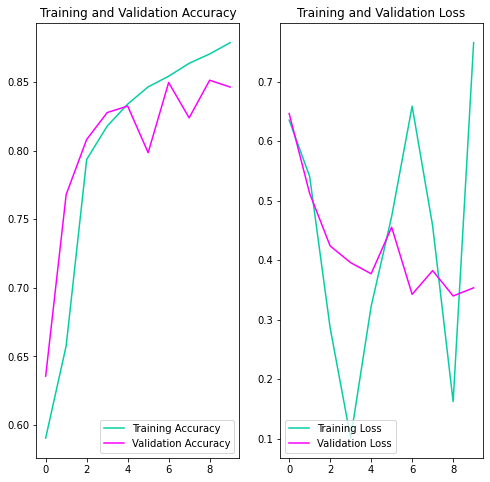

In [23]:
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history['train_accuracy'], label='Training Accuracy', color='#03CEA4')
plt.plot(epochs_range, history['test_accuracy'], label='Validation Accuracy', color='#fc00ff')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history['train_loss'], label='Training Loss', color='#03CEA4')
plt.plot(epochs_range, history['test_loss'], label='Validation Loss', color='#fc00ff')
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')
plt.show()
